# Fused fiber photometry analysis
A new system is in development with data in a new file format. In the *data.txt*, there is some data relative to an experiment done to test the detection system. The first three lines looks like this:
```
274122854225148,01211
274122854342393,10131
274122854471116,01121
```
Before the coma, this is the time in nanosecond since epoch time. After the coma, the first and second element correspond to the state of the LEDs (0 is OFF and 1 is ON). The last number is the state of the system, it's 1 or 0. Between the second and last number, this is the value of the detection (between 0 and 1023).

Your task is to import the data, extract the data and format it in a dataframe (Pandas). This is the format wanted:

|       |Time|  LED0|  LED1 | Photodiode | Slave|
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
|0 | 274122854225148    | 0    | 1       |   21     | 1|
|1 | 274122854342393    | 1    | 0       |  13      |1|
|2 | 274122854471116    | 0    | 1       |   12     | 1|

After you imported the data, correct the time and using the method `groupby()` of Pandas, plot the value of the photodiode for each LED and the corrected fluorescent signal.

## Import the data
What modules should you use?

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# Import the data and store it in the lines variable.
with open("/home/antoine/Desktop/Python-Crash-Course/Project 1/data.txt") as f:
    lines = f.readlines()

print("First line:", lines[0])

First line: 274122854225148,01211



## Extract the data
Be sure to save numbers in your lists. You might want to split the data (or not) and slice things up.

In [40]:
# Initialise some lists for the different data type
time = []
led0 = []
led1 = []
sensor_val = []
slave_ttl = []

# First, split to get the time. After slice to get the position wanted.
# Always convert it to int, you want numbers, not strings.

for i in lines:
    data = i.split(",")
    time.append(int(data[0]))
    led0.append(int(data[1][0]))
    led1.append(int(data[1][1]))
    sensor_val.append(int(data[1][2:-2]))
    slave_ttl.append(int(data[1][-2]))

## Format the data
Find the correct module and open the documentation.

In [41]:
df = pd.DataFrame(data={"Time":np.asarray(time),
                     "LED0":np.asarray(led0),
                     "LED1":np.asarray(led1),
                     "Photodiode":np.asarray(sensor_val),
                     "Slave":np.asarray(slave_ttl)})

print(df.head())

              Time  LED0  LED1  Photodiode  Slave
0  274122854225148     0     1          21      1
1  274122854342393     1     0          13      1
2  274122854471116     0     1          12      1
3  274122854556442     1     0          14      1
4  274122854640737     0     1          13      1


## Correct the data
Would be nice to have data in seconds that start at the begining of the experiment. The method used to group the data is given.

In [42]:
df["Time"] -= df["Time"][0]
df["Time"] /= 1e9

print(df.head())

       Time  LED0  LED1  Photodiode  Slave
0  0.000000     0     1          21      1
1  0.000117     1     0          13      1
2  0.000246     0     1          12      1
3  0.000331     1     0          14      1
4  0.000416     0     1          13      1


In [43]:
df_led1, df_led0 = df.groupby(["LED0"])
df_led0 = df_led0[1]
df_led1 = df_led1[1]

df_led0.index = range(len(df_led0))
df_led1.index = range(len(df_led1))

photodiode_df = df_led0.merge(df_led1, how='left', left_index=True,
                              right_index=True)

## Plot the data
Would be great to have the z-score of my signal. I would also like to see the LED0 and LED1 traces.

In [44]:
def z_score(signal:np.array) -> np.array:
    """Function that return the z-score for a signal. If the population mean
    and population standard deviation are known, a raw score x is converted
    into a standard score by: 
    
    z=(x-μ) / σ

    where:
        μ is the mean of the population,\n
        σ is the standard deviation of the population.
    The absolute value of z represents the distance between that raw score x
    and the population mean in units of the standard deviation. z is negative
    when the raw score is below the mean, positive when above.

    Based on https://en.wikipedia.org/wiki/Standard_score

    Args:
        signal (np.array): Input 1D signal.

    Returns:
        np.array: Z-score of the original signal.
    """
    signal_array = np.asarray(signal)
    return (signal_array - np.mean(signal_array)) / np.std(signal_array)


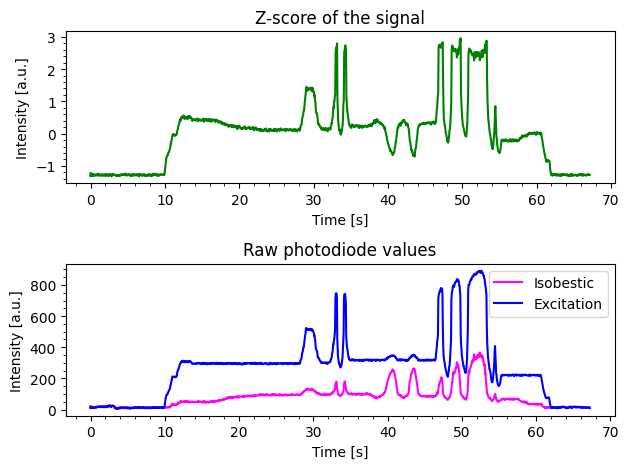

In [45]:
fig, (ax0, ax1) = plt.subplots(2)

ax0.set_title("Z-score of the signal")
ax0.plot(photodiode_df["Time_y"], 
         z_score(photodiode_df["Photodiode_y"] - photodiode_df["Photodiode_x"]),
         color="green")

ax1.set_title("Raw photodiode values")
ax1.plot(df_led0["Time"], df_led0["Photodiode"], color="magenta",
         label="Isobestic")
ax1.plot(df_led1["Time"], df_led1["Photodiode"], color="blue",
         label="Excitation")
ax1.legend()

for i in (ax0, ax1):
    i.set_ylabel("Intensity [a.u.]")
    i.set_xlabel("Time [s]")
    i.minorticks_on()

plt.tight_layout()
plt.show()
